# Finsler Fire Spread Model with Optimisation
This notebook revisits the deterministic anisotropic (Finsler) fire-spread model, starting from the geometric interpretation and solver, then shows how the production `fire_model` package builds on top for optimisation workflows.

## 1) Finsler interpretation
Let $T(x)$ be the arrival time (seconds) of the flame front at cell $x$. If the direction-dependent spread rate is $S(x, \hat v)$, then $T$ satisfies an anisotropic eikonal / Finsler equation\n\n$$|\nabla T(x)|_* = \frac{1}{S(x, \hat v)}$$\n\nwhere the dual norm $|\cdot|_{*}$ comes from a Finsler metric. On a grid we approximate this by direction-dependent edge costs in a shortest-path problem.

In [ ]:
import numpy as np
import heapq
from matplotlib import pyplot as plt

from fire_model import FireEnv, FinslerFireModel, RetardantDropBayesOpt


## 4) Environment setup
We build a heterogeneous grid (fuel/value gradients plus wind shear) so anisotropy is apparent.

In [2]:
nx = ny = 90
domain_km = 2.7
dt_s = 60.0
burn_time_s0 = 15 * 60
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
value = 1.0 + 3.0 * np.exp(-4.0 * ((xs - 0.2) ** 2 + (ys + 0.1) ** 2))
wind = np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 3.5
wind[..., 1] = 0.5 + 0.8 * xs[:, 0][:, None]
env = FireEnv(
    grid_size=(nx, ny), domain_km=domain_km, fuel=fuel, value=value, wind=wind, dt_s=dt_s,
    burn_time_s0=burn_time_s0, retardant_half_life_s=2400.0, retardant_k=1.25, drop_w_km=0.18,
    drop_h_km=0.9, drop_amount=2.0, ros_mps=0.42, wind_coeff=0.6, diag=True
)


## 5) Deterministic Finsler simulation
Ignite near the centre, evolve to the planned drop time, and visualise the affected region.

In [4]:
finsler_model = FinslerFireModel(env, diag=True, k_wind=0.45, w_ref=5.0)
ignition_center = (nx // 2, ny // 2 - 6)
ignition_radius_km = 0.2
drop_time_s = 15 * 60
evolution_time_s = 45 * 60
init_firestate = finsler_model.simulate_from_ignition(T=drop_time_s, center=ignition_center, radius_km=ignition_radius_km)
finsler_model.plot_firestate(init_firestate, kind="affected", title=f"Baseline Finsler state at t={drop_time_s / 60:.1f} min")


AttributeError: 'FinslerFireModel' object has no attribute 'normalize_wind_bias'

## 6) Fire boundaries at ignition vs drop time
Contours extracted at $p=0.25$ show deterministic growth without retardant.

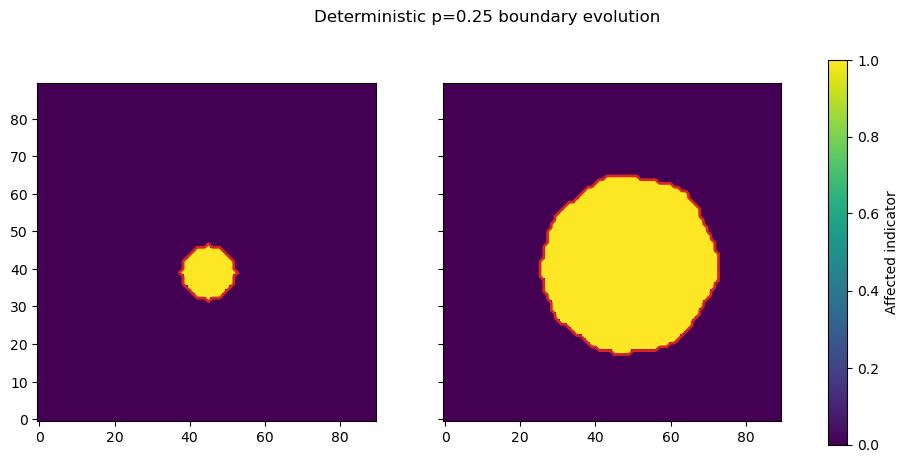

In [ ]:
boundary_prob = 0.25
boundary_K = 360
state_t0 = finsler_model.firestate_at_time(0.0)
state_t15 = init_firestate
boundary_t0 = finsler_model.extract_fire_boundary(state_t0, K=boundary_K, p_boundary=boundary_prob)
boundary_t15 = finsler_model.extract_fire_boundary(state_t15, K=boundary_K, p_boundary=boundary_prob)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
for ax, state, boundary, label in [(axes[0], state_t0, boundary_t0, "t = 0 min"), (axes[1], state_t15, boundary_t15, f"t = {drop_time_s / 60:.0f} min")]:
    field = (state.burning[0] | state.burned[0]).astype(float)
    im = ax.imshow(field.T, origin="lower", aspect="equal")
    ax.plot(boundary.xy[:, 0], boundary.xy[:, 1], color="tab:red", linewidth=2)
plt.colorbar(im, ax=axes.ravel().tolist(), label="Affected indicator")
plt.suptitle(f"Deterministic p={boundary_prob} boundary evolution")
plt.show()


## 7) Boundary uncertainty via wind perturbations
To visualise uncertainty we perturb the wind field across multiple runs and aggregate the resulting affected masks/boundaries.

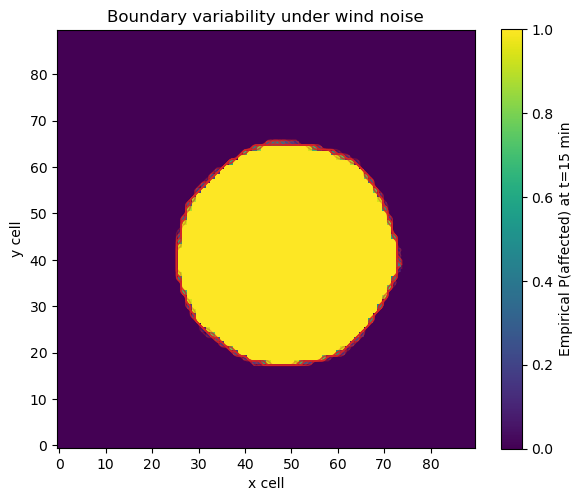

In [ ]:
n_uncertain = 16
wind_sigma = 0.8
boundary_samples = []
prob_acc = np.zeros(env.grid_size, dtype=float)
rng_uncert = np.random.default_rng(2025)
for _ in range(n_uncertain):
    noisy_wind = wind + rng_uncert.normal(scale=wind_sigma, size=wind.shape)
    env_noisy = FireEnv(grid_size=env.grid_size, domain_km=env.domain_km, fuel=fuel, value=value, wind=noisy_wind, dt_s=env.dt_s, burn_time_s0=env.burn_time_s0, retardant_half_life_s=env.retardant_half_life_s, retardant_k=env.retardant_k, drop_w_km=env.drop_w_km, drop_h_km=env.drop_h_km, drop_amount=env.drop_amount, ros_mps=env.ros_mps, wind_coeff=env.wind_coeff, diag=env.diag)
    model_noisy = FinslerFireModel(env_noisy, diag=finsler_model.diag, k_wind=finsler_model.k_wind, w_ref=finsler_model.w_ref)
    state_noisy = model_noisy.simulate_from_ignition(T=drop_time_s, center=ignition_center, radius_km=ignition_radius_km)
    affected = (state_noisy.burning[0] | state_noisy.burned[0]).astype(float)
    prob_acc += affected
    boundary_samples.append(model_noisy.extract_fire_boundary(state_noisy, K=200, p_boundary=boundary_prob))
prob_field = prob_acc / n_uncertain
plt.figure(figsize=(6, 5))
im = plt.imshow(prob_field.T, origin="lower", vmin=0.0, vmax=1.0, aspect="equal")
for b in boundary_samples:
    plt.plot(b.xy[:, 0], b.xy[:, 1], color="tab:red", alpha=0.35, linewidth=1.0)
plt.colorbar(im, label="Empirical P(affected) at t=15 min")
plt.title("Boundary variability under wind noise")
plt.xlabel("x cell")
plt.ylabel("y cell")
plt.tight_layout()
plt.show()


## 8) Optimisation scaffold
Plug the deterministic Finsler simulator into the shared retardant optimisation stack.

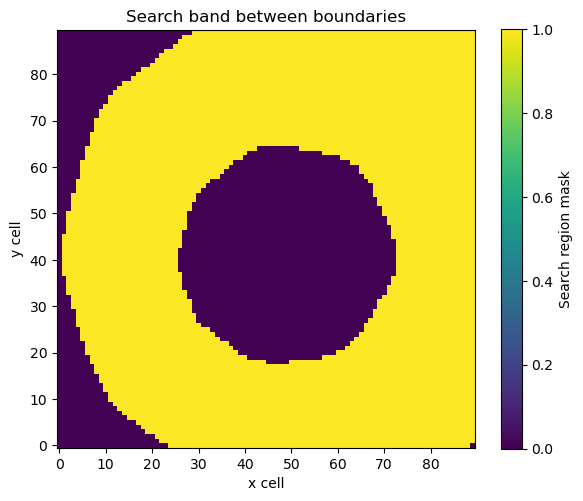

In [ ]:
rng = np.random.default_rng(1234)
drop_opt = RetardantDropBayesOpt(fire_model=finsler_model, init_firestate=init_firestate, n_drones=2, evolution_time_s=evolution_time_s, n_sims=1, fire_boundary_probability=0.25, rng=rng)
final_state_no_drop = finsler_model.simulate_from_firestate(init_firestate, T=evolution_time_s, n_sims=1)
search_mask, coords = drop_opt.setup_search_grid(K=400, boundary_field="affected")
finsler_model.plot_search_domain(search_mask, title="Search band between boundaries")

## 9) Random search baseline
A brute-force scan over the admissible band serves as a sanity check.

In [ ]:
rand_theta, rand_params, rand_value, (_, rand_y), rand_trace, rand_best = drop_opt.run_random_search(n_evals=20, verbose=True, print_every=5)
print(f"Random-search best expected loss: {rand_value:.3f}")
print("Best (x, y, phi) per drone:", rand_params)


[Random] eval 001/20 | y=10.4516 | best=10.4516
        (x,y,phi) per drone:
        [[23.         28.          0.7419891 ]
 [87.         34.          5.80092717]]
[Random] eval 005/20 | y=10.6044 | best=10.151
        (x,y,phi) per drone:
        [[14.         78.          2.75801441]
 [47.          0.          1.57875779]]
[Random] eval 010/20 | y=10.5981 | best=10.151
        (x,y,phi) per drone:
        [[41.         66.          5.37463594]
 [84.         67.          2.96596795]]
[Random] eval 015/20 | y=10.6002 | best=10.151
        (x,y,phi) per drone:
        [[44.         18.          1.47156003]
 [85.         12.          5.01211036]]
[Random] eval 020/20 | y=10.3048 | best=10.151
        (x,y,phi) per drone:
        [[18.         50.          2.38951504]
 [72.         11.          5.97744269]]
[Random] done: best_y=10.151
[Random] best params:
[[22.         28.          6.05748855]
 [23.         39.          3.83193131]]
Random-search best expected loss: 10.151
Best (x, y, p

## 10) Bayesian optimisation
Run BO with the same GP kernel used for the CA model.

[BO] init: n_init=6, dim=6, n_cells=5617
[BO] init: best_y=10.4106, mean_y=10.5593, std_y=0.0695944


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 001/15 | y_next=10.6792 | best_y=10.4106 (no-improve) | EI_max=0.00467 | mu=10.4388 | std=0.044
      proposed (x,y,phi) per drone:
      [[42.         68.         -3.265227  ]
 [76.         79.          3.52987939]]
      gp.kernel_ = 1.04**2 * TiedXYFiMatern(lx=0.0998, ly=1e+03, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 005/15 | y_next=10.5671 | best_y=10.4106 (no-improve) | EI_max=0.000422 | mu=10.5485 | std=0.0697
      proposed (x,y,phi) per drone:
      [[36.         63.          4.02946667]
 [68.         76.          5.64780702]]
      gp.kernel_ = 1.05**2 * TiedXYFiMatern(lx=14.7, ly=0.00648, lphi=58, nu=2.5) + WhiteKernel(noise_level=5.45e-05)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda

[BO] iter 010/15 | y_next=10.3767 | best_y=10.3438 (no-improve) | EI_max=0.00174 | mu=10.3866 | std=0.04
      proposed (x,y,phi) per drone:
      [[ 5.         61.          4.73003838]
 [18.         70.          5.3288071 ]]
      gp.kernel_ = 0.898**2 * TiedXYFiMatern(lx=1e+03, ly=0.216, lphi=0.644, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/min

[BO] iter 015/15 | y_next=10.4331 | best_y=10.3438 (no-improve) | EI_max=0.000991 | mu=10.3985 | std=0.0409
      proposed (x,y,phi) per drone:
      [[ 1.         45.          4.80063597]
 [25.         67.          5.0349226 ]]
      gp.kernel_ = 0.901**2 * TiedXYFiMatern(lx=1e+03, ly=0.0837, lphi=0.623, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] done: best_y=10.3438
[BO] best params:
[[55.         67.          1.88828832]
 [76.         72.          4.24613485]]
BO best expected loss: 10.344
Optimised (x, y, phi) per drone: [[55.         67.          1.88828832]
 [76.         72.          4.24613485]]


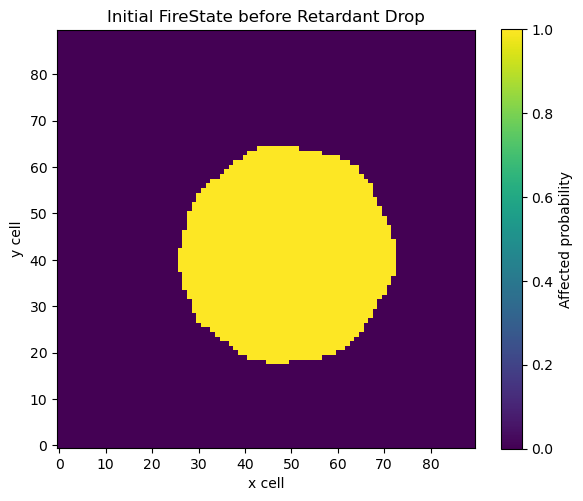

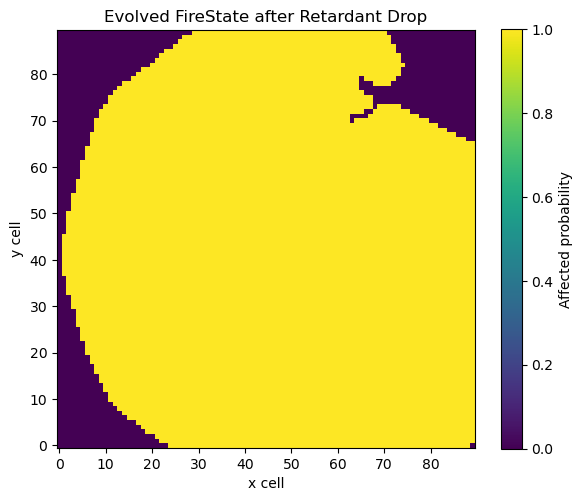

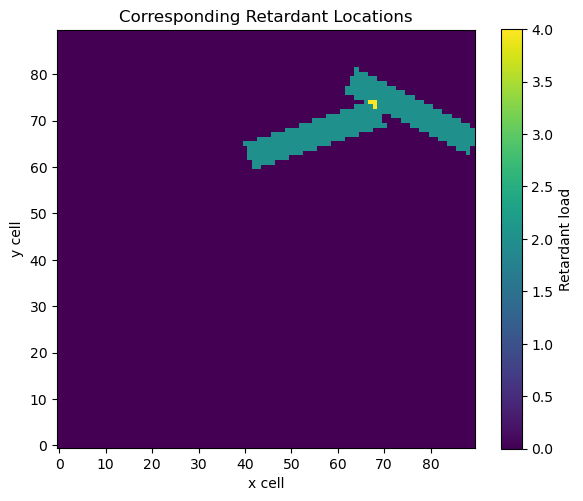

In [ ]:
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(n_init=6, n_iters=15, n_candidates=2000, verbose=True, print_every=5)
print(f"BO best expected loss: {best_value:.3f}")
print("Optimised (x, y, phi) per drone:", best_params)
drop_opt.plot_evolved_firestate(best_theta, n_sims=1)